In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
from flows.models import VARmodel
import flows

import numpy as np
import pandas as pd
from tensorflow.contrib.distributions import WishartCholesky
import math
from tqdm import tqdm_notebook as tqdm
import pickle as pkl

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

ccodes = ['AUS', 'FRA', 'GBR']
datas = ['./CDATA/{}.csv'.format(x) for x in ccodes]

datas = [pd.read_csv(x, index_col='VARIABLE').iloc[:,:-1] for x in datas]

mean_std = 0.
for data in datas:
    std = np.std(data.values[:,1:] - data.values[:,:-1], axis=1)
    mean_std = std + mean_std
mean_std /= len(datas)
mean_std = np.concatenate([mean_std]*2, axis=0)
print('Mean std: {}'.format(mean_std))

max_year = 0
for i, data in enumerate(datas):
    data = data.astype(floatX)
    data.columns = data.columns.astype('float32')
    
    new_data = np.concatenate([data.values.T[1:], data.values.T[:-1]], axis=1)
    new_data_columns = data.columns[1:]
    new_data = pd.DataFrame(new_data.T/mean_std[:,np.newaxis], columns=new_data_columns)
    data = new_data
    datas[i] = data
    max_year = max(max(data.columns), max_year)

VAR_DIM = 4

YEARS = [x for x in data.columns if x > 2000]

country_data = {c:d for c,d in zip(ccodes, datas)}


#BUILDING the model

current_year = tf.placeholder(tf.float32, shape=(), name='current_year')
tf.summary.scalar('current_year', current_year)

with tf.variable_scope('variation_rate', dtype=floatX):
    variation_prior = tf.distributions.Exponential(rate=.3)
    dim_ = (VAR_DIM*2+1)*VAR_DIM
    variation_mu = tf.get_variable('mu', shape=[dim_], initializer=tf.constant_initializer(math.log(0.3)))
    variation_presigma = tf.get_variable('presigma', shape=[dim_], initializer=tf.constant_initializer(-3.))
    variation_d = LogNormal(dim=dim_, mu=variation_mu, sigma=tf.exp(variation_presigma))
    
    variation = variation_d.sample()

    pp = tf.cast(tf.reduce_sum(variation_prior.log_prob(tf.cast(variation, tf.float32))), floatX)
    ld = variation_d.logdens(variation)
    tf.add_to_collection('logdensities', ld)
    tf.add_to_collection('priors', pp)

    tf.summary.histogram('variation', variation)
    tf.summary.scalar('mean_variation', tf.reduce_mean(variation))
    
global_aux = variation[tf.newaxis]
global_inf = DFlow([NVPFlow(dim=(VAR_DIM*2+1)*VAR_DIM, 
                            name='flow_{}'.format(i), 
                            aux_vars=global_aux) for i in range(6)], init_sigma=0.02)

global_prior = Normal(None, sigma=.3).logdens(global_inf.output)
tf.add_to_collection('priors', global_prior)
tf.add_to_collection('logdensities', global_inf.logdens[0])

individ_variation_prior = Normal((VAR_DIM*2+1)*VAR_DIM, sigma=variation, mu=global_inf.output[0])

models = []
indiv_logdens = []
indiv_priors = []
indivs = {}

with tf.variable_scope(tf.get_variable_scope(), dtype=floatX, reuse=tf.AUTO_REUSE):
    for country, data in country_data.items():
        with tf.variable_scope(country):
            aux = tf.concat([global_inf.output, variation[tf.newaxis]], axis=-1)
            individ_variation = DFlow([NVPFlow((VAR_DIM*2+1)*VAR_DIM, 
                                               name='nvp_{}'.format(i), 
                                               aux_vars=aux) for i in range(6)], init_sigma=0.01)

            ind = individ_variation.output[0] 

            indiv_logdens.append(individ_variation.logdens)
            indiv_priors.append(individ_variation_prior.logdens(ind))
            ind += global_inf.output[0]
            indivs[country] = ind


        model = VARmodel(data, name='{}_model'.format(country), var_dim=VAR_DIM, mu=ind[tf.newaxis], current_year=current_year)
        models.append(model)

graph = tf.get_default_graph()

prior = tf.reduce_sum([model.priors for model in models])+ tf.reduce_sum(indiv_priors) + tf.reduce_sum(graph.get_collection('priors'))

logdensity = tf.reduce_sum([model.logdensities for model in models])+ tf.reduce_sum(indiv_logdens) + tf.reduce_sum(graph.get_collection('logdensities'))

kl = logdensity - prior
kl /= 36*200*4


kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge_all()

lr = tf.Variable(0.0001, name='learning_rate', trainable=False)
main_op = tf.train.AdamOptimizer(lr).minimize(kl)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

init.run()

writer = tf.summary.FileWriter('/home/nikita/tmp/tblogs/custom_gvar_exp_variation_rate0.3_varcond_jup_unfixedmu_global_aux')

Mean std: [0.00997741 1.20220203 0.00878533 0.04104758 0.00997741 1.20220203
 0.00878533 0.04104758]
ldiag logdens Tensor("AUS_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1, 1), dtype=float64)
Prior disp: [0.6759642  0.70666791 0.61292328 0.81643079]
Tensor("AUS_model/moments/Squeeze_1:0", shape=(4,), dtype=float64) Tensor("AUS_model/DiagPart:0", shape=(4,), dtype=float64)
ldiag logdens Tensor("FRA_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1, 1), dtype=float64)
Prior disp: [0.28649601 0.38744743 0.28630463 0.36744264]
Tensor("FRA_model/moments/Squeeze_1:0", shape=(4,), dtype=float64) Tensor("FRA_model/DiagPart:0", shape=(4,), dtype=float64)
ldiag logdens Tensor("GBR_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1, 1), dtype=float64)
Prior disp: [0.53445377 0.40242546 0.56184663 0.31931321]
Tensor("GBR_model/moments/Squeeze_1:0", shape=(4,), dtype=float64) Tensor("GBR_model/DiagPart:0", shape=(4,), dtype=float64)


In [3]:
epoch = 0

In [33]:
for epoch in tqdm(range(epoch, epoch+1000)):
    fd = {current_year:3000.}
    for step in range(100):
        sess.run(main_op, fd)
    s, _ = sess.run([summary, main_op], fd)
    writer.add_summary(s, global_step=epoch)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

In [26]:
# ced = tf.concat([indivs['AUS'][tf.newaxis], global_inf.output], axis=0)

In [27]:
# lr.assign(0.0001/2).eval()

In [34]:
ss = []
for _ in range(3000):
    ss.append(ced.eval())
ss = np.array(ss)

In [35]:
import seaborn as sns 
from matplotlib import pyplot as plt

In [36]:
ss.shape

(3000, 2, 36)

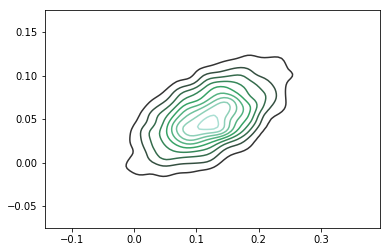

In [37]:
sns.kdeplot(ss[:,0,2], ss[:,1,2])
plt.show()

In [38]:
variation_mu.eval()

array([-1.95796948, -2.14528398, -2.36693058, -2.3798737 , -1.46244247,
       -1.81491193, -2.30747196, -2.30731229, -0.93238291, -2.2618607 ,
       -2.18181562, -2.42284636, -2.29618529, -2.1902332 , -1.79010068,
       -2.16418842, -2.23482298, -2.16939891, -1.93462819, -2.34468146,
       -2.38134722, -1.80443967, -1.31174851, -1.93521794, -2.22677798,
       -2.04549214, -1.65328004, -2.32757256, -2.39236982, -1.92712745,
       -1.62744548, -2.08916456, -1.9383034 , -1.47996646, -1.99107157,
       -2.19384026])

In [41]:
model = models[0]

In [45]:
ss = []
for _ in range(1000):
    s = np.diag(model.PWalk.sigma.eval())
    ss.append(s)
ss = np.array(s)

In [46]:
np.mean(ss, axis=0)

0.00010586900636879881

In [44]:
variation_mu.eval()

array([-2.08377764, -2.19565769, -2.38552616, -2.41974167, -1.53264109,
       -1.93411148, -2.4061373 , -2.35841828, -1.06644807, -2.32582367,
       -2.2548661 , -2.44654297, -2.32128425, -2.26154837, -1.79960517,
       -2.26582283, -2.27121221, -2.18508882, -2.06766524, -2.37045925,
       -2.40135171, -1.91377672, -1.44858054, -2.03700814, -2.09611606,
       -2.05700562, -1.76110175, -2.3884886 , -2.41109639, -2.0414698 ,
       -1.76332451, -2.19497869, -2.03931734, -1.6120852 , -2.01137108,
       -2.21478669])